In [178]:
from __future__ import division, print_function
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from itertools import combinations
import keras.backend as K
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplpath
from scipy.spatial.distance import cosine, cdist

from learning2learn.util import get_hidden_representations, similarity
from learning2learn.images import (generate_random_shape, generate_texture, 
                                   get_base_image, generate_image, generate_colors,
                                   add_texture, Texture)

## First, try this with one of our small CNN models trained on artificial image data

In [119]:
N = 20
IMG_SIZE = (200, 200)
model = load_model('../data/model.h5')
model.layers

In [121]:
def image_gen(shape, color, texture, target_size):
    generate_image(shape, color, texture, save_file='./temp.png')
    # Finally, load the image and return
    img = image.load_img('./temp.png', target_size=target_size)
    img = image.img_to_array(img)
    img /= 255.
    
    return img

In [248]:
def modHausdorffDistance(itemA, itemB):
    """
    Modified Hausdorff Distance
    
    Input
     itemA : [n x 2] coordinates of "inked" pixels
     itemB : [m x 2] coordinates of "inked" pixels
    
     M.-P. Dubuisson, A. K. Jain (1994). A modified hausdorff distance for object matching.
     International Conference on Pattern Recognition, pp. 566-568.
    """
    
    D = cdist(itemA, itemB)
    mindist_A = D.min(axis=1)
    mindist_B = D.min(axis=0)
    mean_A = np.mean(mindist_A)
    mean_B = np.mean(mindist_B)
    return max(mean_A,mean_B)

In [262]:
def euclidean(x1, x2):
    return np.linalg.norm(x1 - x2)

def get_scores(values, nb_categories, distance_fn):
    scores = []
    i_vals = []
    j_vals = []
    for i, j in combinations(range(nb_categories), 2):
        i_vals.append(i)
        j_vals.append(j)
        score = distance_fn(values[i], values[j])
        scores.append(score)
    df = pd.DataFrame()
    df['i'] = i_vals
    df['j'] = j_vals
    df['score'] = scores
    
    return df

def bias_vs_feature_similarity(X_h, df):
    df_sorted = df.sort_values(by='score')
    biases = []
    similarities = []
    for k in range(len(df_sorted)):
        pair = df_sorted.iloc[k]
        i = int(pair['i'])
        j = int(pair['j'])
        similarities.append(pair['score'])
        biases.append(similarity(X_h[i], X_h[j]))
    
    return biases, similarities

def run_experiment(model, nb_categories, target_feature, other_constant=True):
    assert target_feature in ['shape', 'color']
    # Choose one of ['ellipse', 'arc', 'arrow', 'circle', 'rectangle', 'wedge', 'pentagon'].
    # The texture will have no gradient for now.
    texture = generate_texture('ellipse', gradient=None, image_size=500)
    if target_feature == 'shape':
        # Generate 'nb_categories' random shapes
        values = [np.asarray(generate_random_shape(0, 500, 0, 500, 100)) for _ in range(nb_categories)]
        # Generate 2 random colors
        other1 = np.random.uniform(0, 1, size=3)
        other2 = np.random.uniform(0, 1, size=3)
        df = get_scores(values, nb_categories, distance_fn=modHausdorffDistance)
        imgs = np.asarray(
            [image_gen(value, other1, texture, target_size=IMG_SIZE) for value in values]
        )
    else:
        # Generate 'nb_categories' random colors
        values = np.random.uniform(low=0, high=1, size=(N,3))
        # Generate 2 random shapes
        other1 = generate_random_shape(0, 500, 0, 500, 100)
        other2 = generate_random_shape(0, 500, 0, 500, 100)
        #df = get_scores(values, nb_categories, distance_fn=euclidean)
        df = get_scores(values, nb_categories, distance_fn=cosine)
        imgs = np.asarray(
            [image_gen(other1, value, texture, target_size=IMG_SIZE) for value in values]
        )
        
    imgs_h = get_hidden_representations(model, imgs, layer_num=-4, batch_size=32)
    # Compute biases and similarities
    biases, similarities = bias_vs_feature_similarity(imgs_h, df)

    return imgs, df, biases, similarities

### First, try parametrically varying shape

In [263]:
imgs, df, biases, similarities = run_experiment(model, N, target_feature='shape')

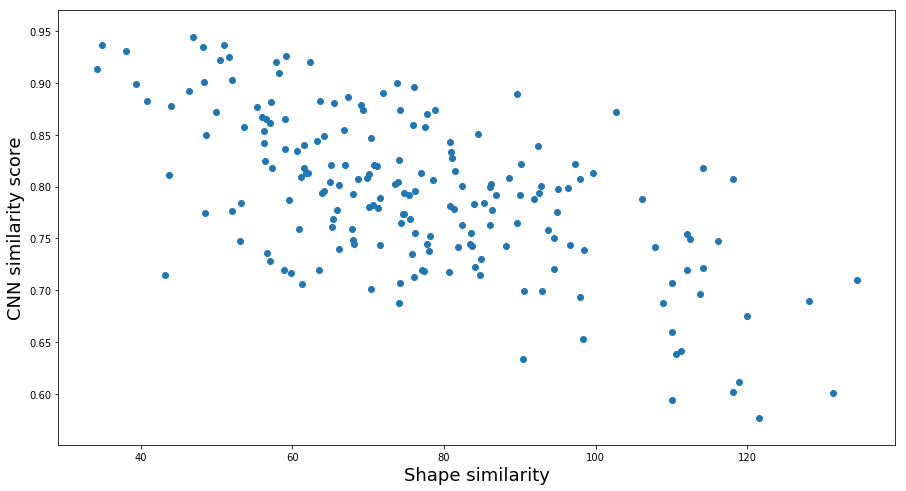

In [264]:
# Plot results
plt.figure(figsize=(15,8))
plt.scatter(similarities, biases)
plt.xlabel('Shape similarity', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.show()

In [252]:
def plot_two(x1, x2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    axes[0].imshow(x1)
    axes[0].axis('off')
    axes[1].imshow(x2)
    axes[1].axis('off')
    plt.show()

Distance between shape #14 and shape #19: 34.19


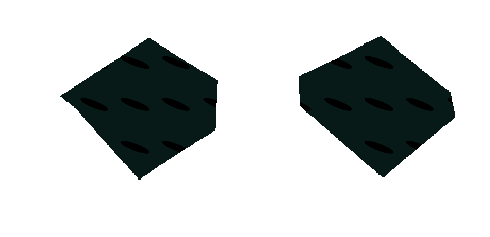

Distance between shape #7 and shape #19: 34.92


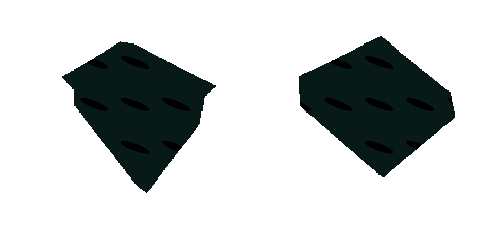

Distance between shape #4 and shape #19: 38.06


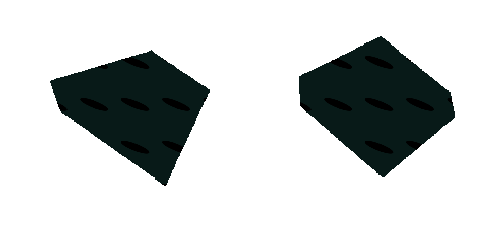

Distance between shape #7 and shape #10: 39.40


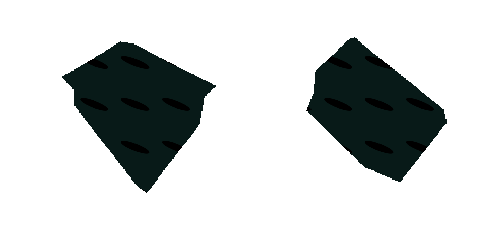

Distance between shape #7 and shape #14: 40.81


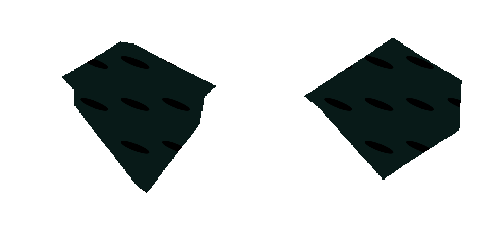

Distance between shape #7 and shape #9: 43.18


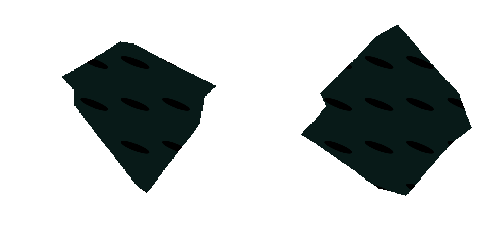

Distance between shape #9 and shape #14: 43.70


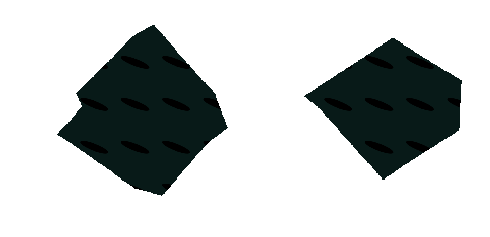

Distance between shape #7 and shape #15: 43.96


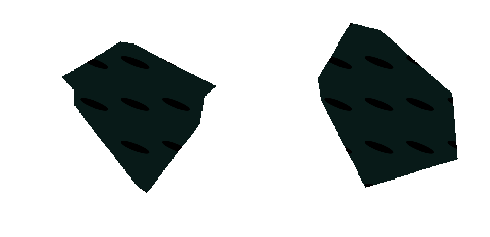

Distance between shape #10 and shape #13: 46.40


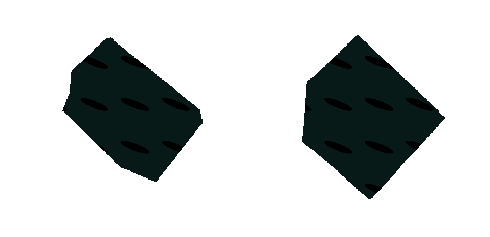

Distance between shape #8 and shape #16: 46.93


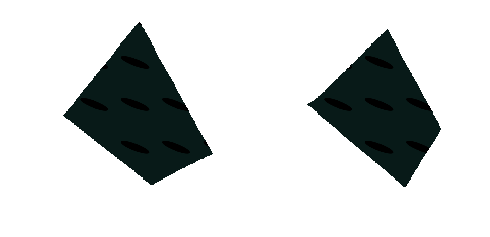

In [265]:
df_sorted = df.sort_values(by='score')
for k in range(10):
    pair = df_sorted.iloc[k]
    i = int(pair['i'])
    j = int(pair['j'])
    score = pair['score']
    print('Distance between shape #%i and #%i: %0.2f' % (i, j, score))
    plot_two(imgs[i], imgs[j])

### Now, try parametrically varying color

In [266]:
imgs, df, biases, similarities = run_experiment(model, N, target_feature='color')

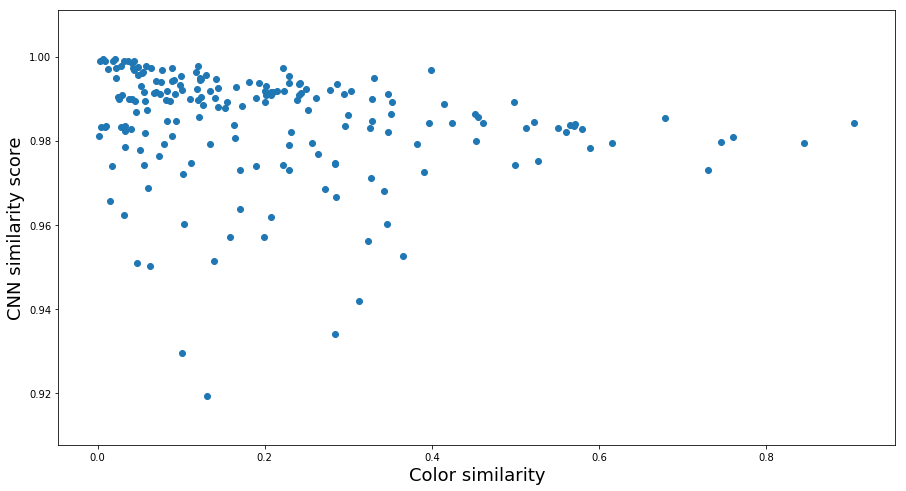

In [267]:
# Plot results
plt.figure(figsize=(15,8))
plt.scatter(similarities, biases)
plt.xlabel('Color similarity', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.show()

Distance between color #5 and #13: 0.00


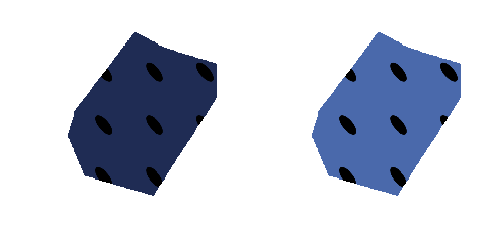

Distance between color #2 and #18: 0.00


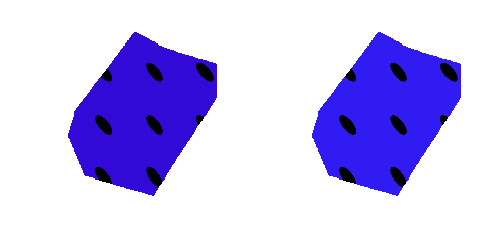

Distance between color #10 and #14: 0.00


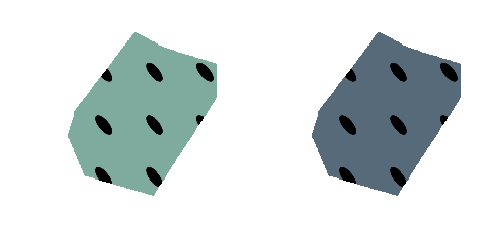

Distance between color #7 and #10: 0.01


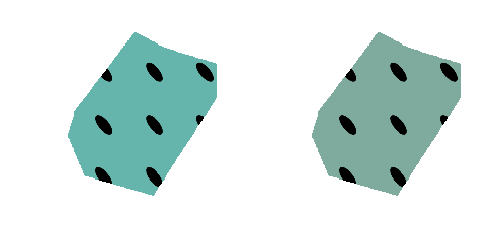

Distance between color #15 and #16: 0.01


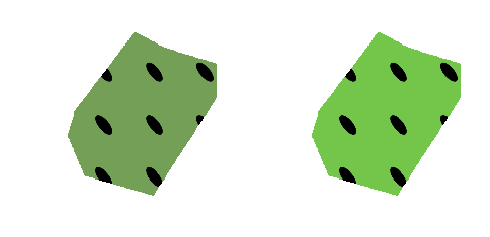

Distance between color #7 and #14: 0.01


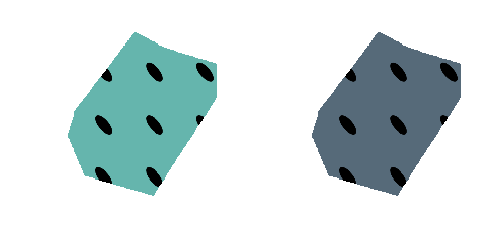

Distance between color #0 and #7: 0.01


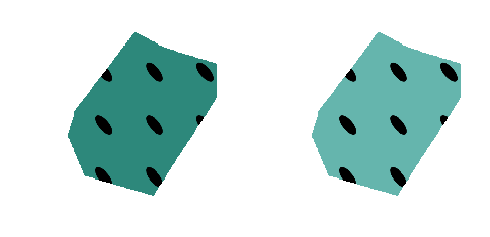

Distance between color #11 and #13: 0.01


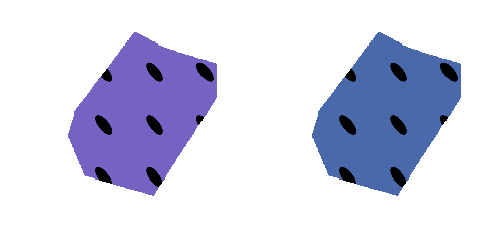

Distance between color #5 and #11: 0.02


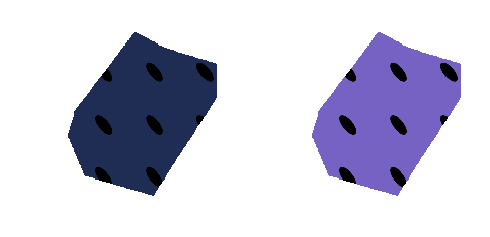

Distance between color #8 and #15: 0.02


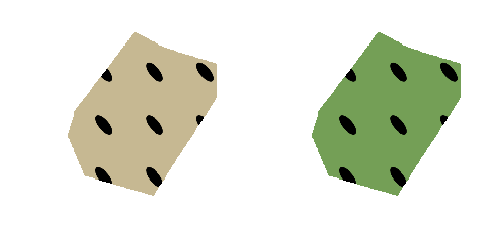

In [268]:
df_sorted = df.sort_values(by='score')
for k in range(10):
    pair = df_sorted.iloc[k]
    i = int(pair['i'])
    j = int(pair['j'])
    score = pair['score']
    print('Distance between color #%i and #%i: %0.2f' % (i, j, score))
    plot_two(imgs[i], imgs[j])

In [ ]:
# Leave this code here for now...

In [242]:
imgs1 = [image_gen(shape1, color, texture, target_size=IMG_SIZE) for color in colors]
imgs2 = [image_gen(shape2, color, texture, target_size=IMG_SIZE) for color in colors]

Distance between color #4 and color #19: 0.00


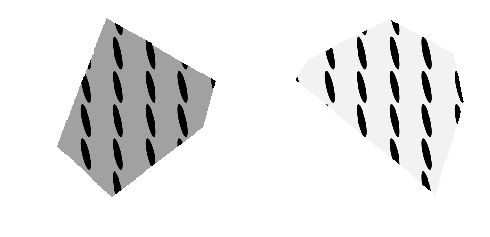

Distance between color #4 and color #18: 0.02


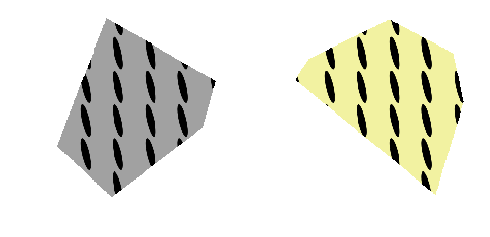

Distance between color #4 and color #17: 0.02


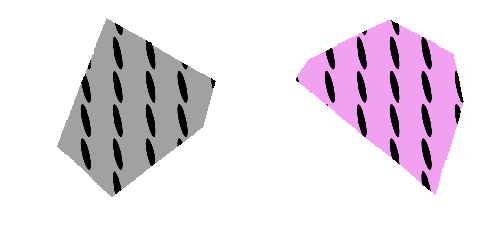

Distance between color #4 and color #16: 0.02


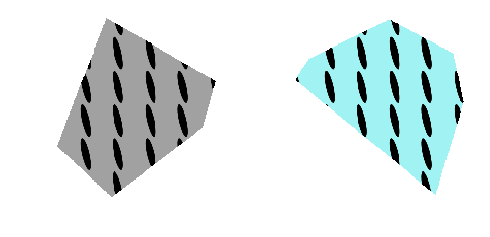

Distance between color #18 and color #19: 0.02


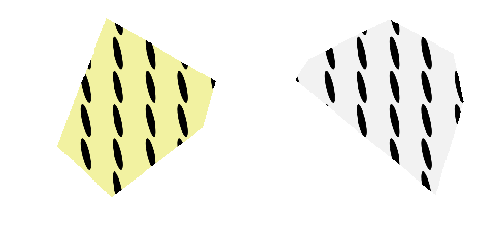

Distance between color #16 and color #19: 0.02


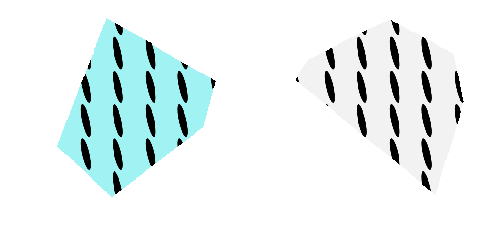

Distance between color #17 and color #19: 0.02


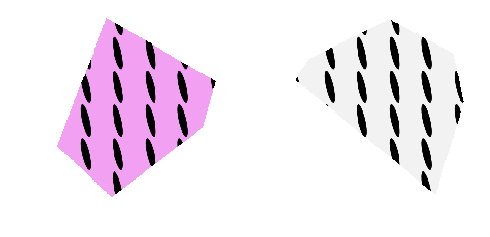

Distance between color #14 and color #18: 0.02


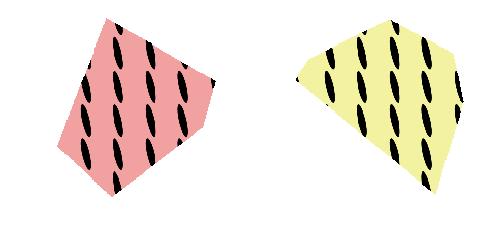

Distance between color #14 and color #17: 0.02


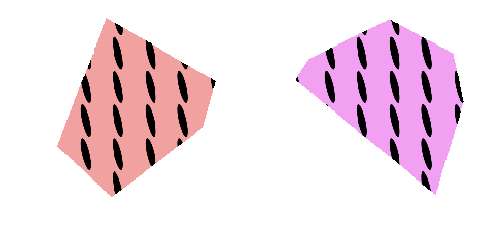

Distance between color #12 and color #18: 0.02


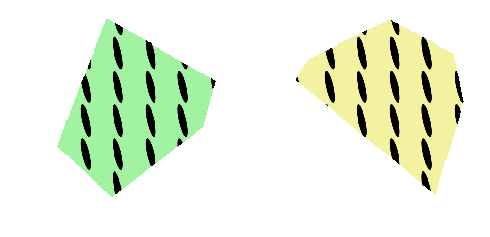

Distance between color #12 and color #16: 0.02


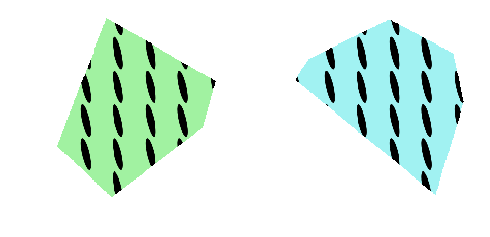

Distance between color #11 and color #17: 0.02


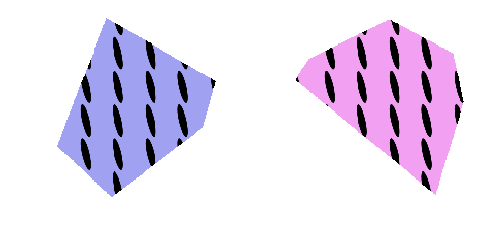

Distance between color #11 and color #16: 0.02


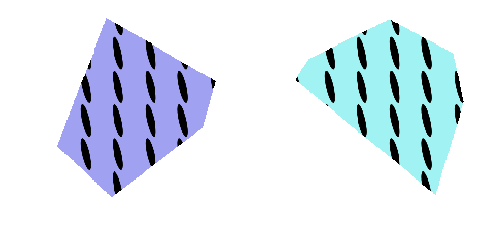

Distance between color #8 and color #15: 0.02


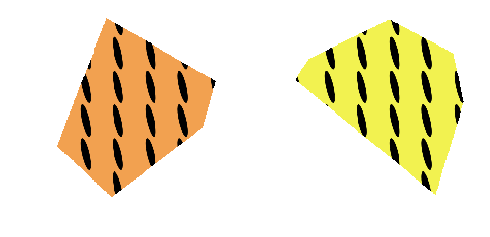

Distance between color #5 and color #15: 0.02


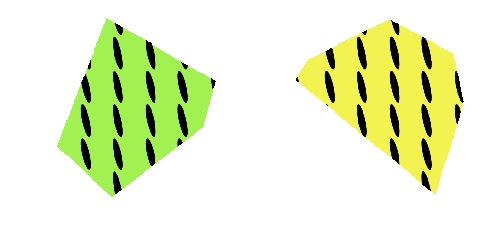

Distance between color #7 and color #13: 0.02


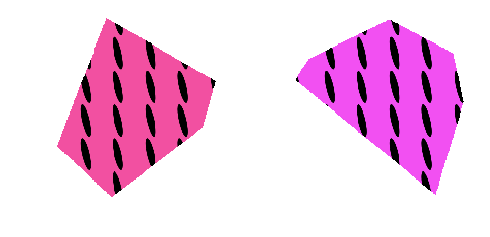

Distance between color #3 and color #13: 0.02


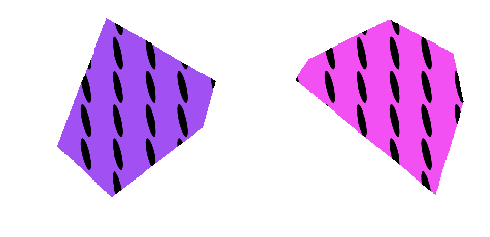

Distance between color #2 and color #10: 0.02


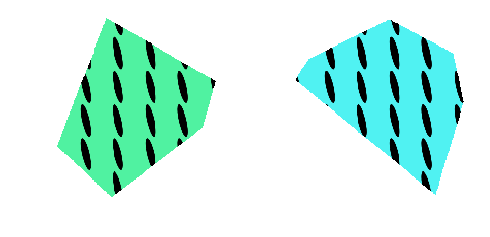

Distance between color #1 and color #10: 0.02


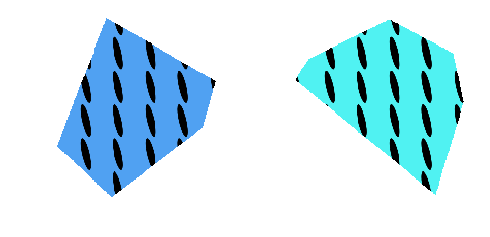

Distance between color #4 and color #14: 0.02


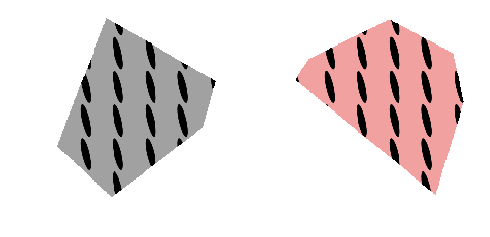

In [243]:
df_sorted = df.sort_values(by='cosine')
for k in range(20):
    pair = df_sorted.iloc[k]
    i = int(pair['i'])
    j = int(pair['j'])
    score = pair['cosine']
    print('Distance between color #%i and color #%i: %0.2f' % (i, j, score))
    plot_two(imgs1[i], imgs2[j])

In [244]:
def bias_vs_feature_similarity1(X_h1, X_h2, df, by):
    df_sorted = df.sort_values(by=by)
    biases = []
    similarities = []
    for k in range(len(df_sorted)):
        pair = df_sorted.iloc[k]
        i = int(pair['i'])
        j = int(pair['j'])
        similarities.append(pair[by])
        biases.append(similarity(X_h1[i], X_h2[j]))
    
    return biases, similarities

In [245]:
imgs_h1 = get_hidden_representations(model, np.asarray(imgs1), layer_num=-4, batch_size=32)
imgs_h2 = get_hidden_representations(model, np.asarray(imgs2), layer_num=-4, batch_size=32)

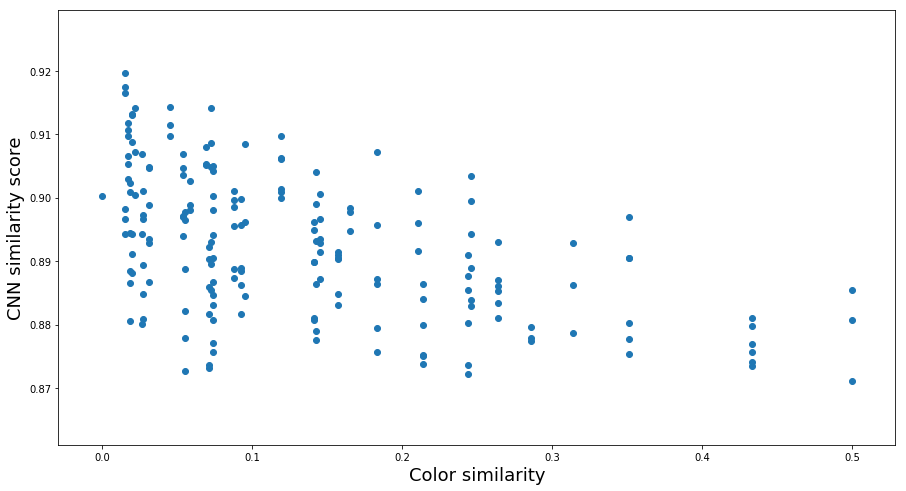

In [246]:
# Compute biases and similarities
biases, similarities = bias_vs_feature_similarity1(imgs_h1, imgs_h2, df, by='cosine')
# Plot results
plt.figure(figsize=(15,8))
plt.scatter(similarities, biases)
plt.xlabel('Color similarity', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.show()

In [12]:
model = VGG16(weights='imagenet', include_top=True)